In [19]:
import numpy as np
import matplotlib.pyplot as plt
from dm_control import suite, viewer
from tqdm import tqdm
from ddpg import DDPGagent
from utils import *

In [20]:
random_state = np.random.RandomState(42)

PATH_MODEL = 'ddpg_actor.pt'
NUM_EPISODES = 1000
BATCH_SIZE = 128
DURATION = 100
ACTOR_LEARNING_RATE=1e-4
CRITIC_LEARNING_RATE=1e-3
GAMMA=0.99
TAU=1e-2

env = suite.load('cheetah', 'run', task_kwargs={'random': random_state})
action_spec = env.action_spec()
obs_spec = env.observation_spec()
dim_action = action_spec.shape[0]
dim_obs = sum(tuple(map(lambda x: x.shape[0], obs_spec.values())))

agent = DDPGagent(
    dim_obs,
    dim_action,
    actor_learning_rate=ACTOR_LEARNING_RATE,
    critic_learning_rate=CRITIC_LEARNING_RATE,
    gamma=GAMMA,
    tau=TAU
)
noise = OUNoise(dim_action, action_spec.minimum, action_spec.maximum)

def denorm(a): #  use on model output before passing to env
    act_k = (action_spec.maximum - action_spec.minimum) / 2.
    act_b = (action_spec.maximum + action_spec.minimum) / 2.
    return a * act_k + act_b

def norm(a): # use on env output before passing to model
    act_k_inv = 2. / (action_spec.maximum - action_spec.minimum)
    act_b = (action_spec.maximum + action_spec.minimum) / 2.
    return act_k_inv * (a - act_b)

def parse(obs):
    """
    We lose information about the variables when we combine, for instance,
    velocity and position into 1 long array of observations. Could treating
    them separately lead to a better NN architecture? Velocity, position
    and numerical integration for instance take only ...
    """
    x = np.array([])
    for _, v in obs.items():
        x = np.append(x, v)
    return x

def off_policy():
    return np.random.uniform(action_spec.minimum, action_spec.maximum, size=action_spec.shape)

  0%|          | 0/1000 [00:00<?, ?it/s]c:\users\leeji\pycharmprojects\algorithms\venv\lib\site-packages\numpy\core\fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\users\leeji\pycharmprojects\algorithms\venv\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 1000/1000 [22:41<00:00,  1.36s/it]


episode: 0, reward: 0.83, average_reward: nan
episode: 1, reward: 0.45, average_reward: 0.8285235489123723
episode: 2, reward: 2.12, average_reward: 0.6410548634844515
episode: 3, reward: 2.88, average_reward: 1.1328145258255924
episode: 4, reward: 0.95, average_reward: 1.5688133330841376
episode: 5, reward: 1.73, average_reward: 1.4442163506186136
episode: 6, reward: 2.64, average_reward: 1.4913458014823455
episode: 7, reward: 5.24, average_reward: 1.655297613362419
episode: 8, reward: 11.28, average_reward: 2.103922984485992
episode: 9, reward: 7.17, average_reward: 3.123719574791174
episode: 10, reward: 3.21, average_reward: 3.5278888129863915
episode: 11, reward: 8.82, average_reward: 3.7662480638390052
episode: 12, reward: 3.43, average_reward: 4.602599738830689
episode: 13, reward: 4.13, average_reward: 4.734240791911342
episode: 14, reward: 5.46, average_reward: 4.859420235715728
episode: 15, reward: 13.11, average_reward: 5.310711643602394
episode: 16, reward: 4.23, average_rew

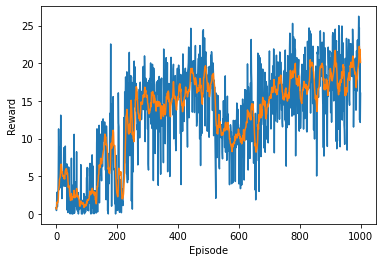

In [21]:
rewards = []
avg_rewards = []

for episode in tqdm(range(NUM_EPISODES)):
    time_step = env.reset()
    state = parse(time_step.observation)
    noise.reset()
    episode_reward = 0

    for step in range(DURATION):

        # initially, add only successful tasks to memory
        # if episode < NUM_WARMUP:
        #     action = off_policy()
        #     time_step_2 = env.step(action)
        #     state_2 = parse(time_step_2.observation)
        #     if time_step_2.reward > 0:
        #         agent.memory.push(state, action, time_step_2.reward, state_2, -1)
        #     state = state_2
        #
        # else:
        action = agent.get_action(state)
        action = noise.get_action(action, step)
        time_step_2 = env.step(denorm(action))
        state_2 = parse(time_step_2.observation)
        agent.memory.push(state, action, time_step_2.reward, state_2, -1)
        state = state_2
        if len(agent.memory) > BATCH_SIZE:
            agent.update(BATCH_SIZE)
        episode_reward += time_step_2.reward
    if episode_reward > 0:
        print(f"episode: {episode}, "
          f"reward: {np.round(episode_reward, decimals=2)}, "
          f"average_reward: {np.mean(rewards[-10:])}")
    rewards.append(episode_reward)
    avg_rewards.append(np.mean(rewards[-10:]))

agent.save(PATH_MODEL)

plt.plot(rewards)
plt.plot(avg_rewards)
plt.plot()
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()

In [1]:
agent.load(PATH_MODEL)
# Define a uniform random policy.
def random_policy(time_step):
    state = parse(time_step.observation)
    return denorm(agent.get_action(state))

# Launch the viewer application.
viewer.launch(env, policy=random_policy)

NameError: name 'agent' is not defined